# 02477 Bayesian Machine Learning - Exercise 1

In [6]:
%matplotlib inline
from math import comb

import matplotlib.pyplot as plt
import numpy as np
import seaborn as snb

from scipy.stats import binom as binom_dist
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_fun

snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3


The purpose of this exercise is to become familiar with the core components of Bayesian inference: the **prior**, the **likelihood**, **posterior** and **the model evidence**. We will also re-cap various ways to summarize distributions, e.g. **mean**, **mode**, **variance**, and **intervals**, and we will look into how to compute and manipulate probabilities using sampling. We will study these concepts in the context of the Beta-Binomial model, which is the "Hello world"-equivalent of Bayesian statistics.

One of the main applications of the Beta-Binomial model is to **estimate proportions**. For example, suppose a website shows a specific ad to $N = 112$ customers and $y = 13$ of those costumers end up clicking on the ad. A common task is then to estimate the click-rate for this ad in order to answer questions like the following:

1) What is the probability that the next customer will click on the ad?

2) What is the probability that the click-rate is below 10%?

We will see how the Bayesian Beta-Binomial model can be used to answer such questions. Furthermore, we will conclude the exercise by studying a slightly more general version of the problem: Suppose a website has two ads: version A and version B and that version A was shown $N_A$ times and generated $y_A$ clicks, whereas version B was shown $N_B$ times and generated $y_B$ click. What is the probability that the click-rate of version B is larger than click-rate of version A?

We highly encourage you to discuss your results and conclusions with one of the teachers/teaching assistant to check you understanding. Moreover, if you get stuck with an exercise, don't hesitate to consult the solution or the teachers/teaching assistant.

**Content**

- Part 1: Maximum likelihood estimation
- Part 2: Bayesian inference
- Part 3: The functional form of Beta distributions
- Part 4: Computing summary statistics and probabilities using sampling
- Part 5: Application to A/B testing




## Estimating the proportions using the binomial distribution

In this exercise, we will work with two common families of probabilities distributions: the Binomial distribution and the Beta distribution. 

### The Binomial distribution and maximum likelihood estimation

First we re-cap the ***Binomial distribution***. The Binomial distribution is a discrete probability distribution representing the number of successes in a sequence of **independent Bernoulli trials** and it is specified through its **probability mass function (PMF)**:

$$
\begin{align*}
p(y|N, \theta) &= \text{Bin}(y|N, \theta)\\
&= {N\choose y} \theta^{y}(1-\theta)^{N-y},
\end{align*}$$

where $N$ is the number of trials, $\theta \in \left[0, 1\right]$ is the probability of success in each individual trial and $y \in \left\lbrace 0, 1, \dots, N \right\rbrace$ is the total number of successes. The quantity ${N\choose y}$ is a called a binomial coefficient and is pronounced "$N$ choose $y$" and counts the number of ways $y$ items can be chosen from a set of $N$ items. The simplest way to estimate $\theta$ is through **maximum likelihood estimation (MLE)**, which for this model can be done analytically:

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} p(y|N, \theta) = \frac{y}{N}.$$

We can also compute a classic/frequentist 95%-**confidence interval**:

$$\hat{\theta}_{\text{MLE}} \pm 1.96 \sqrt{\frac{\hat{\theta}_{\text{MLE}}(1-\hat{\theta}_{\text{MLE}})}{N}}.$$

Technically, this type of interval is called a **Wald interval** and relies on a Gaussian approximation, but we won't cover these details in this course. Note that a **confidence interval** is **generally not** the same as a **posterior credibility interval** (see Section 4.6.6 in Murphy1). 

### The beta distribution as prior distribution for the proportion $\theta$

The ***Beta distribution*** is distribution over random variables in the unit interval. The **probability density function (PDF)** of the Beta distribution  has two parameters $\alpha_0 > 0$ and $\beta_0 > 0$ and is given by

$$p(\theta|\alpha_0,\beta_0) = \frac{1}{B(\alpha_0,\beta_0)}\theta^{\alpha_0-1}(1-\theta)^{\beta_0-1},$$

where $B(\alpha_0, \beta_0)$ is a normalization function that ensures that the density integrates to one:

$$B(\alpha_0,\beta_0) = \int \theta^{\alpha_0-1}(1-\theta)^{\beta_0-1} \text{d}\theta = \frac{\Gamma(\alpha_0)\Gamma(\beta_0)}{\Gamma(\alpha_0+\beta_0)},$$

where $\Gamma$ is the so-called gamma function, which we won't dive deeper into in this course. Since $B(\alpha_0,\beta_0)$ is a constant wrt. $\theta$, it holds that

$$p(\theta|\alpha_0,\beta_0) \propto \theta^{\alpha_0-1}(1-\theta)^{\beta_0-1},$$

and therefore, we say that $f(\theta) = \theta^{a-1}(1-\theta)^{b-1}$ is the **functional form** of a Beta distribution for some $a,b > 0$.

The **mean** of a Beta-distributed random variable, $\theta \sim \text{Beta}(\alpha_0, \beta_0)$, is given by

$$\mathbb{E}\left[\theta\right] = \int_0^1 \theta \, p(\theta|\alpha_0,\beta_0) \,\text{d} \theta  = \frac{\alpha_0}{\alpha_0+\beta_0}. \tag{1}$$

The quantity $\mathbb{E}\left[\theta\right]$ is also sometimes refered to as the **expected value** of $\theta$ or the **first moment** of $\theta$. The **variance** of $\theta$ is

$$\mathbb{V}\left[\theta\right] = \int_0^1 \left(\theta - \mathbb{E}\left[\theta\right] \right)^2 \, p(\theta|\alpha_0,\beta_0) \,\text{d} \theta  = \frac{\alpha_0 \beta_0}{(\alpha_0+\beta_0)^2(\alpha_0+\beta_0+1)}.$$

When $\alpha_0, \beta_0 > 1$ the Beta density is unimodal with the mode given by 

$$\theta_{\text{mode}} = \frac{\alpha_0 - 1}{\alpha_0 + \beta_0 - 2}.$$

If needed, you can find more information about both distributions in Section 2.4.1 (Murphy1) in the textbook or on Wikipedia: 

[https://en.wikipedia.org/wiki/Beta_distribution](https://en.wikipedia.org/wiki/Beta_distribution)

[https://en.wikipedia.org/wiki/Binomial_distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

### The Beta-binomial model ###


The beta-binomial model is a Bayesian model for estimating proportions $\theta \in \left[0, 1\right]$, where the **likelihood** is the binomial distribution and a Beta distribution is used as a **prior distribution** for the parameter $\theta$. The key equations for the model are given by

\begin{align*}
    p(\theta) &= \text{Beta}(\theta|\alpha_0, \beta_0)&&\text{(Prior)}\\
    p(y|\theta) &= {N \choose y} \theta^y (1-\theta)^{N-y}&&\text{(Likelihood)}\\
    p(\theta|y) &= \text{Beta}(\theta|\alpha_0 + y, \beta_0 + N-y)&&\text{(Posterior)}
  \end{align*}


for the dataset $\mathcal{D} = \left\lbrace N, y \right\rbrace$. Following the convention of the book, we will the use both $p(\theta|y)$ and $p(\theta|\mathcal{D})$ to refer the posterior distribution of $\theta$ conditioned on $y$. We will often write $p(\theta)$ to denote the prior instead of $p(\theta|\alpha_0,\beta_0)$ and usually only use  the latter if we want to highlight the dependency on the hyperparameters $\alpha_0, \beta_0$. We will typically refer to $\theta$ as the **parameter** of the model and to $\alpha_0, \beta_0$ as **hyperparamters** of the model.  
 

# Part 1:  Maximum likelihood estimation
Assume you want to estimate the probability of success, $\theta \in \left[0, 1\right]$, after observing $y = 1$ successes out of $N = 7$ independent Bernoulli trials. That is, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$.

**Task 1.1**: Plot the likelihood $p(y|\theta)$ as a function of $\theta$ for $\theta \in \left[0,1\right]$ and identify the maximum likelihood solution visually/numerically. 

*Hints:*

- *You can either implement the likelihood function yourself using the equation given above, or you can use the implementation from scipy.stats: binom_dist.pmf(y, n, p), where y is the number of success, n is the number of trials and p is the probability of success.*
- *If you don't know how to get started, study the solution.*



Max likelyhood 0.14285714285714285
95% CI [-0.11637249  0.40208677]


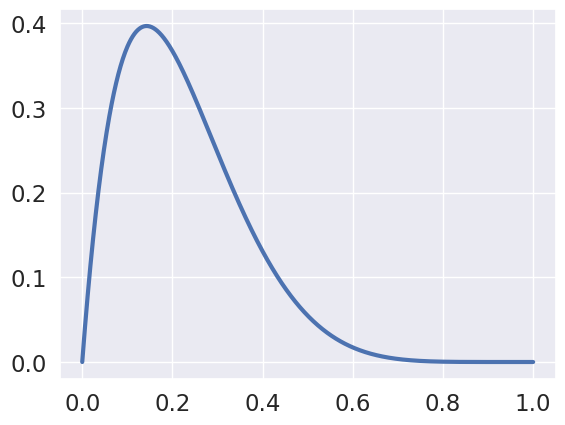

In [16]:
# data
N1 = 7
y1 = 1

# make grid for plotting the likelihood p(y|theta) in interval [0, 1]
thetas = np.linspace(0, 1, 1000)

lik = comb(N1, y1) * thetas**y1 * (1 - thetas)**(N1 - y1)
plt.plot(thetas, lik, label='likelihood')

print("Max likelyhood", (MLE := y1/N1))
print("95% CI", y1/N1 + 1.96 * np.array([-1, 1]) * np.sqrt(MLE * (1 - MLE) / N1))

_ = plt.show()



**Task 1.2**: Compute the maximum likelihood estimate for $\theta$ and compute a 95% confidence interval using the equations given above.



**Task 1.3**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

***Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.**

# Part 2:  Bayesian inference

We will now turn our attention towards Bayesian inference for $\theta$. Recall, the core concept of Bayesian inference is that we infer a **full probability distribution**  for $\theta$ rather than just a **point estimate** like $\hat{\theta}_{MLE}$. 
As before, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$, but now we assume a uniform prior distribution for $\theta$, i.e. $p(\theta) = \text{Beta}(\theta|\alpha_0,\beta_0) = 1$ for $\alpha_0 = \beta_0 = 1$.

**Task 2.1**: Compute the prior mean and variance of $\theta$.




**Task 2.2**: Compute the parameters $\alpha$ and $\beta$ of the posterior distribution $p(\theta|y)$ using the equations for the Beta-binomial model.






**Task 2.3**: Plot the prior density $p(\theta)$, likelihood $p(y|\theta)$, and the posterior density $p(\theta|y)$ as a function of $\theta$ for $\theta \in \left[0, 1\right]$ in the same figure.

*Hints: the functions beta_dist.pdf and binom_dist.pmf might come in handy*




**Task 2.4**: Compute the MAP-estimator for $\theta$ as well as the posterior mean of $\theta$. 

*Hint*: *The MAP-estimator is the mode of the posterior density, i.e. $\theta_{\text{MAP}} = \arg\max\limits_{\theta \in \left[0, 1\right]} p(\theta|y)$*, and can be computed analytically for the Beta-binomoial model.



**Task 2.5**: Compute a 50%, 90% and a 95% posterior credibility interval for $\theta$.

*Hints*:
-  To obtain a 50% posterior credibility interval, our goal is to identify $\theta_1, \theta_2 \in \left[0, 1\right]$ such that  $p(\theta \in \left[\theta_1, \theta_2\right]|\mathcal{D}) = \int _{\theta_1}^{\theta_2} p(\theta|\mathcal{D}) \text{d} \theta  \approx 0.5$
- *scipy.stats.beta.interval* might come in handy for this.




**Task 2.6**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*

**Task 2.7**: Experiment with different values of $\alpha_0$, $\beta_0$, $N$, and $y$ to explore how it affects the results (e.g. the plots, MAP, posterior mean and posterior credibility interval).

**Note**: *This is a discussion question, which means that you actively have to experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs.*




In the next few tasks, we will explore the relationships between the posterior mean and the maximum likelihood estimator.

**Task 2.8** Show that the posterior mean converges to the maximum likelihood estimator $\hat{\theta}_{\text{MLE}} = \frac{y}{N}$ as $N \rightarrow \infty$.

*Hints:*
- *Write the posterior mean as a function of $\alpha_0, \beta_0, N, y$*
- *Write the number of successes as $y = \hat{\theta}_{MLE} N$ and substitute it into the expression for the posterior mean*
- *If you are stuck, don't hesitate to consult the solution or ask the teachers/teaching assistant for an additional hint*





**Task 2.9** Show that the posterior mean is always between the prior mean, $\theta_0 = \frac{\alpha_0}{\alpha_0 + \beta_0}$, and the maximum likelihood estimate $\hat{\theta}_{MLE} = \frac{y}{N}$.

Hints:
- Show that the posterior mean can be written as 

$$
\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right] = (1-\lambda) \theta_0 + \lambda \hat{\theta}_{MLE}
\end{align*}
$$
for some $0 \leq \lambda \leq 1$.





Task 2.1 0.5 0.08333333333333333
Task 2.2 1 8


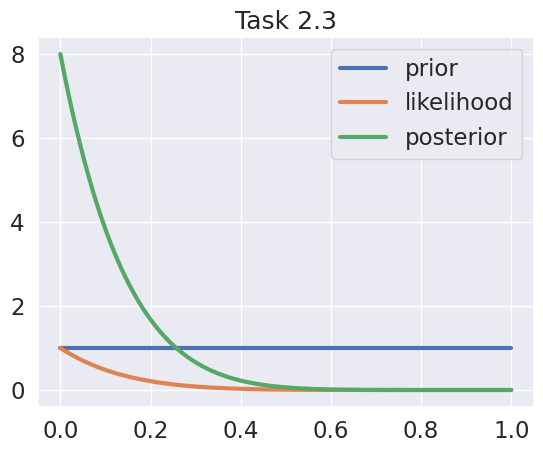

Task 2.4 0.0 0.0
Task 2.5 c=0.5: (0.035321370039690575, 0.15910358474628544) c=0.9: (0.0063911509545449855, 0.3123439780663678) c=0.95: (0.003159723531251909, 0.3694166475528192)


In [43]:
N2 = 7
y2 = 0
a0 = b0 = 1
thetas = np.linspace(0, 1, 1000)

prior_mean = a0 / (a0 + b0)
prior_var = a0 * b0 / ((a0 + b0)**2 * (a0 + b0 + 1))
print("Task 2.1", prior_mean, prior_var)

a1 = a0 + y2
b1 = b0 + N2 - y2
print("Task 2.2", a1, b1)

prior_dist = beta_dist(a0, b0).pdf(thetas)
likelyhood = binom_dist.pmf(y2, N2, thetas)
posterior_dist = beta_dist(a1, b1).pdf(thetas)

plt.plot(thetas, prior_dist, label='prior')
plt.plot(thetas, likelyhood, label='likelihood')
plt.plot(thetas, posterior_dist, label='posterior')
plt.legend()
plt.title('Task 2.3')
_ = plt.show()

print("Task 2.4", thetas[np.argmax(posterior_dist)], (a1 - 1) / (a1 + b1 - 2))

print("Task 2.5", *[f"{c=}: {beta_dist(a1, b1).interval(c)}" for c in (0.5, 0.9, 0.95)])

# Part 3:  The functional form of Beta distributions

Suppose you are given the expression for a probability density function $p_d(\theta)$ up to a constant, i.e. you are told that $p_d(\theta) =   \frac{1}{Z_d}\theta^{36}(1-\theta)^{41}$, where $Z_d > 0$ is an unknown, but positive constant.


**Task 3.1**: Argue the distribution $p_d$ specified above must be a Beta-distribution $p(\theta|\alpha_d, \beta_d)$ and identify its parameters $\alpha_d, \beta_d$.






**Task 3.2**: Compute $Z_d$

*Hint: What is the normalization constant for a Beta distribution?*




We will now use our knowledge of the functional form for Beta densities to compute the denominator in Bayes' theorem, $p(y)$, which is often called the **model evidence**. It can be expressed using the **product rule** and the **sum rule** of probability theory:

$$\begin{align*}
p(y) = \underbrace{\int p(y, \theta) \text{d}\theta}_{\text{sum rule}} = \int \underbrace{p(y|\theta)p(\theta)}_{\text{product rule}} \text{d}\theta .
\end{align*}
$$

Later in the course, we will see that this term can be useful for hyperparameter tuning and model selection. For most models of practical interest, the term will be **intractable** because we cannot solve the integral above analytically.  However, for models like the beta-binomial we actually compute this term in closed-form.

**Task 3.3**: Compute the analytical expression for the  model evidence for the Beta-Binomial model

**Hints**:
- Insert the probability mass function for the binomial likelihood and the probability density function for the beta distribution in the integral given above.
- Use linearity of integrals to "move" constants (wrt. $\theta$) outside the integral
- Identify the resulting integral as the integral of the functional form corresponding to a Beta density.



# Part 4:  Computing summary statistics and probabilities using sampling

Once, we have obtained our posterior distribution of interest, we often compute the relevant summary statistics using sampling when the quantities can not easily be computed analytically. However, we can often generate a set of samples to represent the distribution and then compute the quantities of interest based on the samples. For example,



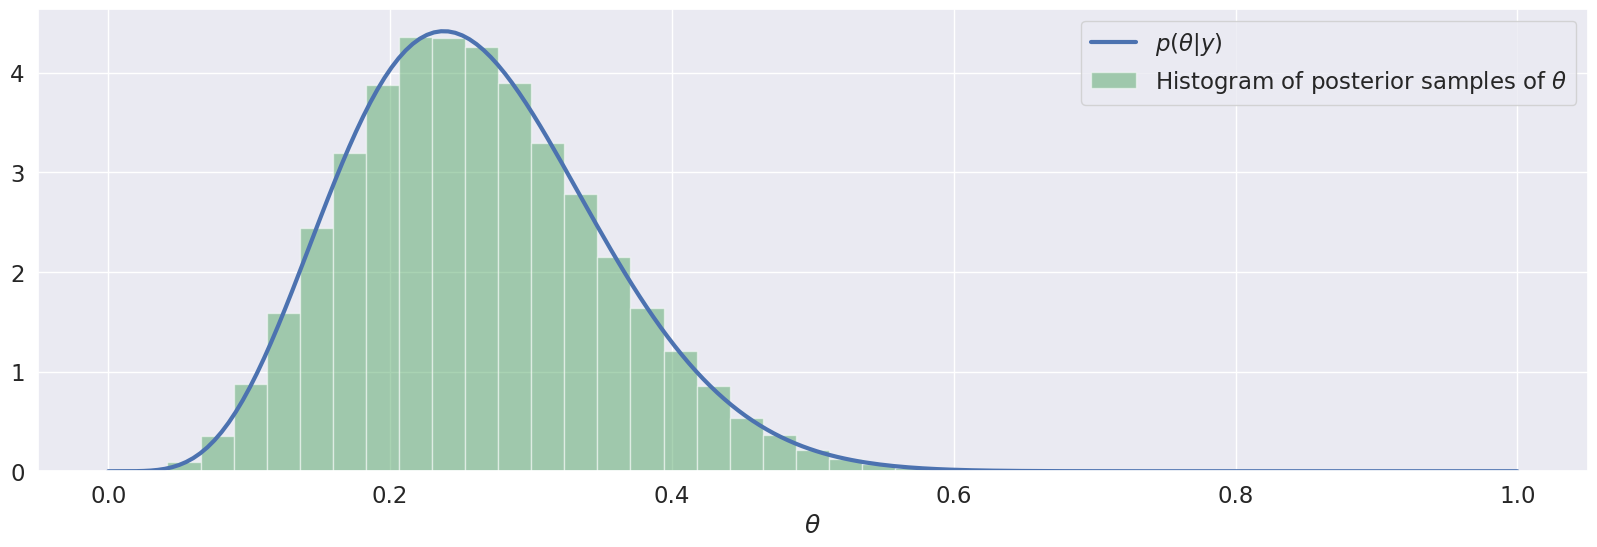

In [3]:
# specify parameters for posterior distribution
alpha = 6
beta = 17

# generate samples
num_samples = 100000
theta_samples = beta_dist.rvs(a=alpha, b=beta, size=num_samples)

# plot
thetas = np.linspace(0, 1, 200)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(thetas, beta_dist.pdf(thetas, a=alpha, b=beta), label='$p(\\theta|y)$')
ax.hist(theta_samples, 30, density=True, label='Histogram of posterior samples of $\\theta$', alpha=0.5, color='g')
ax.set(xlabel='$\\theta$')
ax.legend();

Using the posterior samples $\theta^{(i)} \sim p(\theta|y)$ for $i = 1, \dots, S$, we can easily **estimate** the posterior mean and variance:

In [4]:
analytical_posterior_mean = alpha/(alpha+beta)
analytical_posterior_variance = (alpha*beta)/((alpha+beta)**2*(alpha+beta+1))

print(f'E[theta|D] = {np.mean(theta_samples):5.4f} (estimated using samples)')
print(f'E[theta|D] = {analytical_posterior_mean:5.4f} (analytical solution)\n')
print(f'V[theta|D] = {np.var(theta_samples):5.4f} (estimated using samples)')
print(f'V[theta|D] = {analytical_posterior_variance:5.4f} (analytical solution)')

E[theta|D] = 0.2609 (estimated using samples)
E[theta|D] = 0.2609 (analytical solution)

V[theta|D] = 0.0080 (estimated using samples)
V[theta|D] = 0.0080 (analytical solution)


Sampling is often relatively easy to implement, and hence, it can also be a highly valuable method for verifying analytical results. 

We can also estimate probabilities and credibility intervals using samples as follows. Suppose we want to estimate the posterior probability that $\theta > 0.2$, then we generate $S$ samples from the posterior, i.e. $\theta^{(i)} \sim p(\theta|\mathcal{D})$ for $i = 1, ..., S$, and then simply count the fraction of samples satisfying $\theta^{(i)} < 0.2$. The reason this works is that we can phrase  the probability as an expectation value, which can be estimated using so-called Monte Carlo samples:

$$\begin{align*}
P(\theta > 0.2 | \mathcal{D}) = \int_{0.2}^1 p(\theta|\mathcal{D}) \text{d} \theta = \int_0^1 \mathbb{I}\left[\theta > 0.2\right] p(\theta|\mathcal{D}) \text{d}\theta = \mathbb{E}_{p(\theta|\mathcal{D})}\left[\mathbb{I}\left[\theta > 0.2\right]\right] \approx \frac{1}{S}\sum_{i=1}^S \mathbb{I}\left[\theta^{(i)} > 0.2\right],
\end{align*}$$
where $\mathbb{I}\left[\cdot\right]$ is the indicator function yielding $1$ if the condition in the brackets are true, and 0 otherwise. We will talk much more about Monte Carlo sampling later in the course, but for now, we will simply use it as tool to summarize distributions:

In [5]:
print(f'P[theta > 0.2|D] = {np.mean(theta_samples > 0.2):5.4f}\t\t\t(estimated using sampling)\n')

interval = np.percentile(theta_samples, [2.5, 97.5])
print(f'95% credibility interval: [{interval[0]:4.3f}, {interval[1]:4.3f}]\t(estimated using sampling)')

P[theta > 0.2|D] = 0.7341			(estimated using sampling)

95% credibility interval: [0.107, 0.453]	(estimated using sampling)


Generally, the larger number of samples $S$ used, the more accurate an estimate we will get. Later in the course, we will make this much more precise.

**Example**

A friend of yours is building a classifier for a company, and she asks for your help to evaluate the model. On a independent test set of $N = 100$ examples, the classifier made $y = 8$ errors.  It is critical for the company the error rate is below 10%. Your friend argues that the error rate is $\frac{8}{100} = 0.08$, so there no need to worry, but you are not as convinced because of the rather small test set.

Let $\theta$ represent the error rate and assume a flat Beta-prior, i.e. $\alpha_0 = \beta_0 = 1$. 

**Task 4.1**: Compute the posterior mean of the error rate $\theta$.




**Task 4.2**: Generate $S = 10000$ samples from the posterior distribution and estimate the posterior probability of the test error being larger than $10%$.  Comment on the result.




In [64]:
print((1 + 8) / (1 + 1 + 100))

arr = beta_dist(1 + 8, 1 + 100 - 8).rvs(10_000)
print(arr.mean())

print((arr >= 0.1).mean())

0.08823529411764706
0.08777143522658651
0.3032


# Part 5:  Application to A/B testing



Suppose a website has two ads: version A and version B and that version A was shown $N_A = 947$ times and generated $y_A = 87$ clicks, whereas version B was shown $N_B = 1053$ times and generated $y_B = 101$ click.

We will now put everything together and apply it do a Bayesian analysis of the data using the Beta-binomial model. 

**Task 5.1** Assuming a $\text{Beta}(\theta|2, 2)$ prior for both $\theta_A$ and $\theta_B$, plot the posterior density for both ads.



**Task 5.2** Estimate the mean and a 95%-credibility interval for both ads. Use a $p(\theta) = \text{Beta}(\theta|2, 2)$ prior for both ads.




**Task 5.3** Generate $S = 10000$ posterior samples for both ads and plot the histograms of both sets of samples.



**Task 5.4** Compute posterior samples for the difference of $\theta_D = \theta_B - \theta_A$ and visualize the histogram





**Task 5.5** Compute the posterior mean and 95% credibility interval for $\theta_D$ using the posterior samples



**Task 5.6** What is the posterior probability that the click-rate of version B is larger than click-rate of version A?



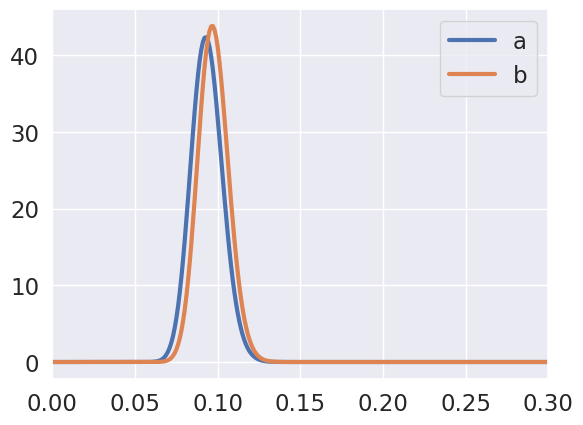

0.6156

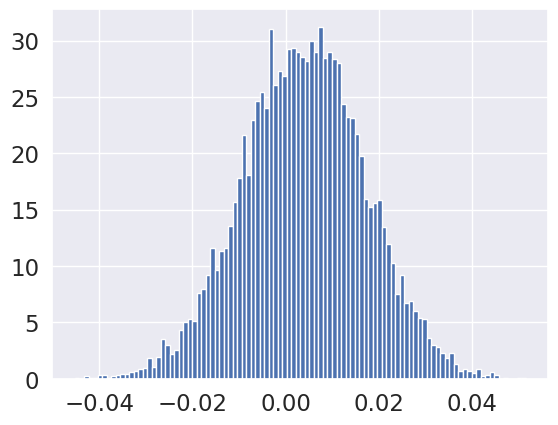

In [73]:
theta = np.linspace(0, 1, 1000)

dist_a = beta_dist(2 + 87, 2 + 947 - 87)
dist_b = beta_dist(2 + 101, 2 + 1053 - 101)

plt.plot(theta, dist_a.pdf(theta), label='a')
plt.plot(theta, dist_b.pdf(theta), label='b')
plt.xlim(0, 0.3)
plt.legend()
plt.show()

dist_a.interval(0.95), dist_b.interval(0.95)

samples = 10_000
arr_a = dist_a.rvs(samples)
arr_b = dist_b.rvs(samples)

diff = arr_b - arr_a

_ = plt.hist(diff, bins=100, density=True)

np.mean(diff > 0)